# A test of unet model `(2D -> 3D)` on SWIR imagery

In [5]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import cv2 

import os
import logging
import sys
sys.path.append("../common/")

from data_utils import TRAIN_LABEL_TILES, TRAIN_DATA, TRAIN_IMAGE_IDS, LABELS
from data_utils import get_resized_polygons, get_filename
from image_utils import get_image_data, generate_label_file
from visu_utils import display_img_1b

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_files if 'mean' not in s and 'std' not in s])
print "First train tile : ", all_train_files[0], all_train_files[-1], len(all_train_files)

First train tile :  6010_1_2 6170_4_1 25


In [18]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

ll = int(len(all_train_files)*0.8)
train_files = all_train_files[:ll]
val_files = all_train_files[ll:]

mean_fname = os.path.join(TRAIN_DATA, 'mean_swir_image.tif')
std_fname = os.path.join(TRAIN_DATA, 'std_swir_image.tif')
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_files, 'swir_aligned')
    logging.getLogger().setLevel(logging.ERROR)
    imwrite(mean_fname, mean_image)
    imwrite(std_fname, std_image)
else:
    mean_image = GeoImage(mean_fname).get_data()
    std_image = GeoImage(std_fname).get_data()

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
print len(train_files), len(val_files)

logging.getLogger().setLevel(logging.ERROR)

(134, 137, 8) (134, 137, 8)
261.6 5654.65 788.311 3489.79
20 5


In [85]:
from image_utils import get_image_data, generate_label_image2
from data_utils import TRAIN_WKT, get_image_ids, get_filename

def swir_images_iterator(image_ids_to_use, 
                         classes, 
                         size, 
                         mean_image=None,
                         std_image=None):
    
    
    gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
    random_rotation_angles=(0.0, 5.0, 0.0, -5.0, 0.0, 15.0, 0.0, -15.0)
    
    while True:

        image_ids = get_image_ids(classes, gb)
        image_ids = list(set(image_ids) & set(image_ids_to_use))
        np.random.shuffle(image_ids)
        
        for i, image_id in enumerate(image_ids):
            
            img_swir = get_image_data(image_id, 'swir_aligned').astype(np.float32)
            img_label = generate_label_image2(image_id, 'swir_aligned')            
            img_label = img_label[:, :, classes]    
            
            if mean_image is not None and std_image is not None:
                h, w, _ = img_swir.shape
                img_swir -= mean_image[:h,:w,:]
                img_swir /= (std_image[:h,:w,:] + 0.00001)

            # Add random rotation and scale
            sc = 1.0
            a = random_rotation_angles[np.random.randint(len(random_rotation_angles))] if len(random_rotation_angles) > 0 else 0.0
            if a != 0 and sc < 1.15:
                sc = 1.15
            h, w, _ = img_swir.shape
            warp_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), a, sc)

            img_swir = cv2.warpAffine(img_swir,
                                      warp_matrix,
                                      dsize=(w, h),
                                      flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

            img_label = cv2.warpAffine(img_label,
                                      warp_matrix,
                                      dsize=(w, h),
                                      flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

            if img_swir.shape[:2] != size[::-1]:                 
                img_swir = cv2.resize(img_swir, dsize=size, interpolation=cv2.INTER_LINEAR)
                img_label = cv2.resize(img_label, dsize=size, interpolation=cv2.INTER_LINEAR)
            
            assert img_swir.shape[:2] == img_label.shape[:2], "Image sizes are not equal: {} != {}".format \
                (img_label.shape[:2], img_swir.shape[:2])
            yield img_swir, img_label

In [118]:
from data_utils import get_image_ids

def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out

def compute_ndvi_like(x, vis_index, nir_index):
    vis = x[:,:,vis_index].astype(np.float32)
    nir = x[:,:,nir_index].astype(np.float32())
    ndvi = (nir - vis) / (nir + vis + 0.00001)
    return ndvi

def generate_ndvi_like_image(img_swir):
    h, w, nc = img_swir.shape
    out = np.zeros((h,w,nc*(nc-1)), dtype=np.float32)
    count = 0
    for vis_index in range(nc):
        vals = list(range(nc))
        vals.remove(vis_index)
        for nir_index in vals:
            out[:,:,count]=compute_ndvi_like(img_swir, vis_index, nir_index)
            count += 1
    return out

def generate_images(image_ids_to_use, batch_size):
    while True:        
        # Input shape should be 5D for Convolution3D
        X = np.zeros((batch_size, 1, n_channels)+size[::-1], dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+size[::-1], dtype=np.float32)
        images = swir_images_iterator(image_ids_to_use, 
                                     labels, 
                                     size=size, 
                                     mean_image=None,
                                     std_image=None)
        counter = 0
        for x, y in images:     
            
            x = generate_ndvi_like_image(x)            
            x = normalize_image(x)
            y = normalize_image(y)     

            X[counter,0,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


In [119]:
shape = get_image_data(TRAIN_IMAGE_IDS[0], 'swir_aligned', return_shape_only=True)

size = (136, 136)
# channels = np.array(range(mean_image.shape[2]))
# channels = np.arange(0,8,dtype=np.uint8)
n_channels = 8
n_channels *= (n_channels-1)

labels = np.array([5, 6, 8, 7])
n_labels = len(labels)

print size, n_channels, labels

(136, 136) 56 [5 6 8 7]


(5, 1, 56, 136, 136) (5, 4, 136, 136)
-0.710499 0.710499 0.0 1.0


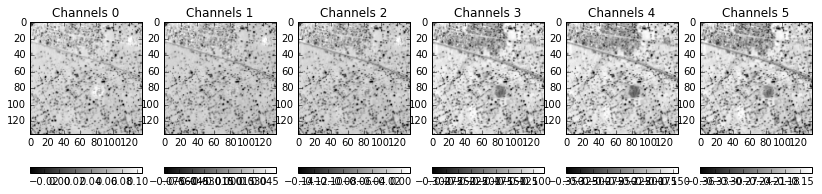

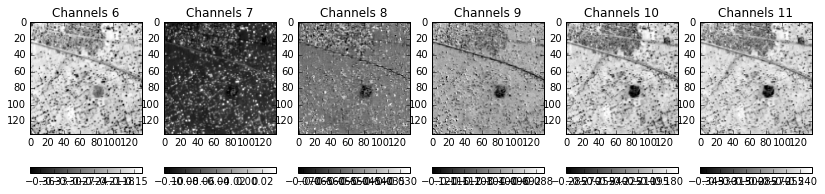

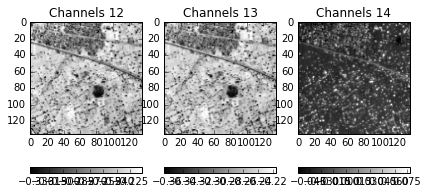

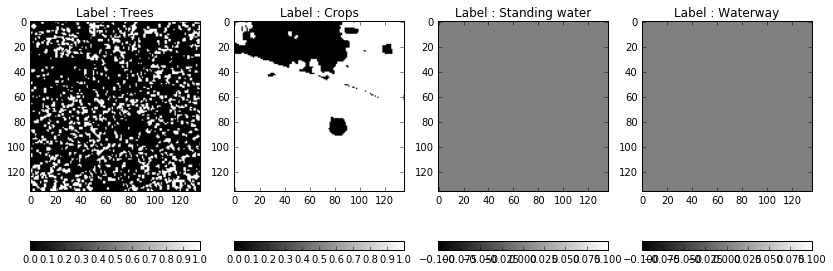

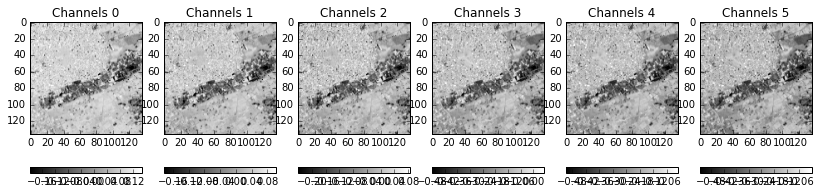

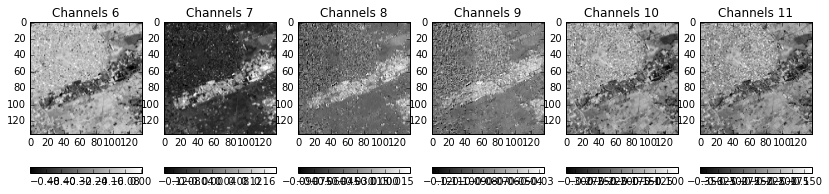

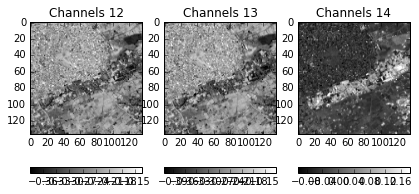

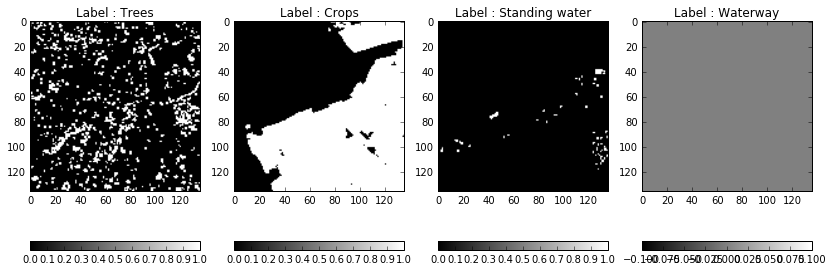

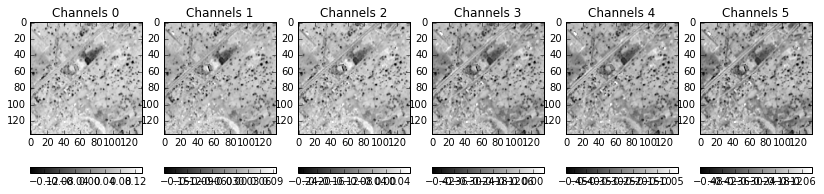

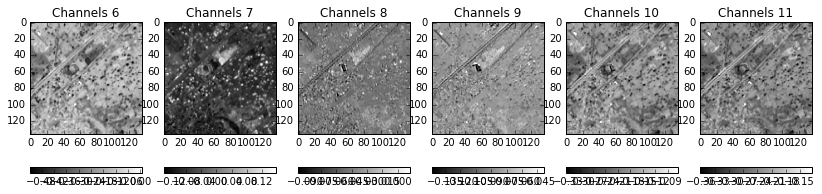

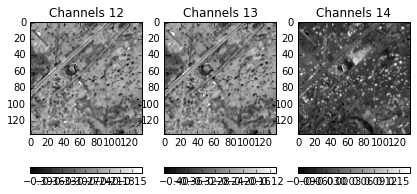

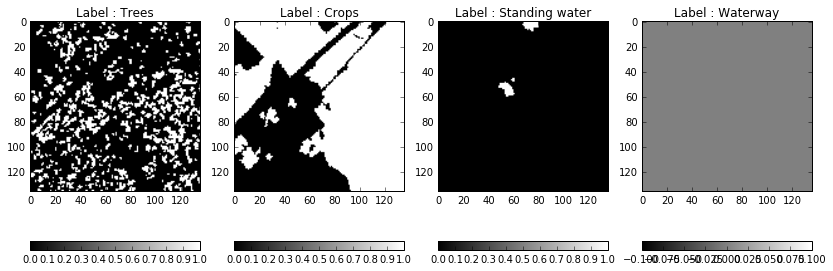

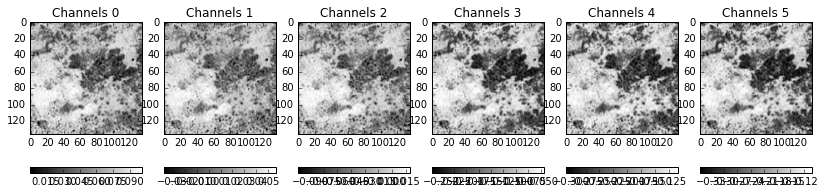

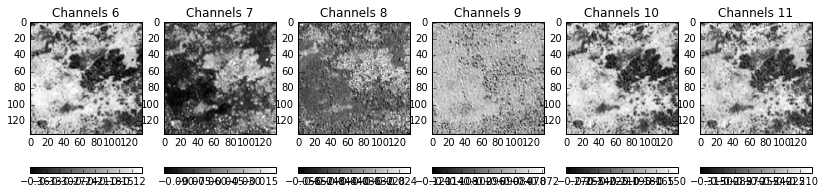

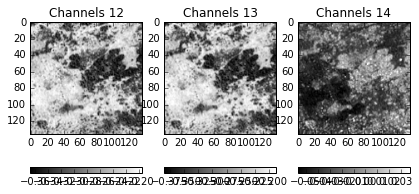

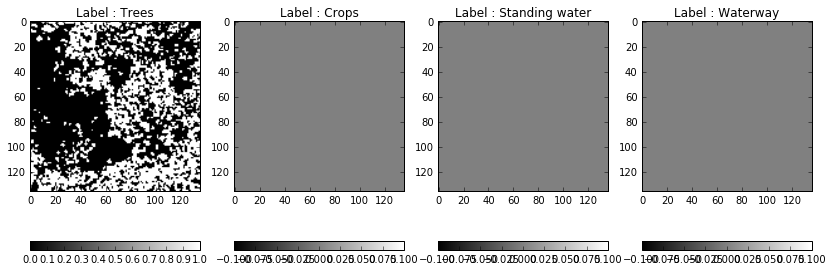

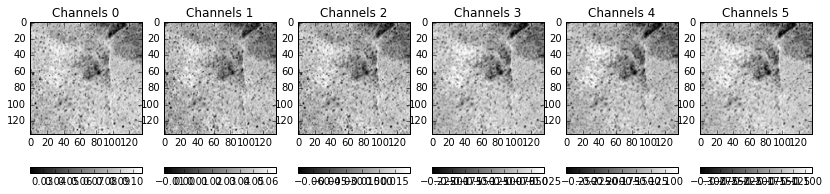

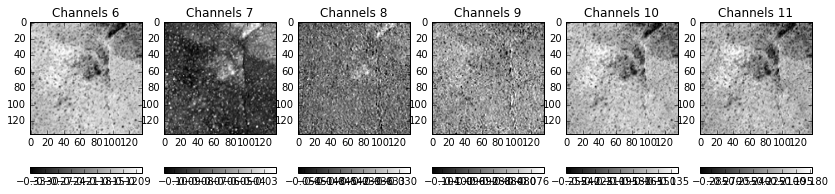

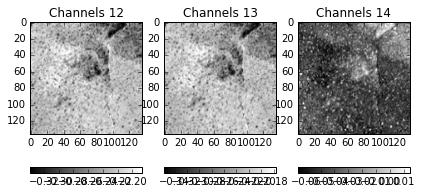

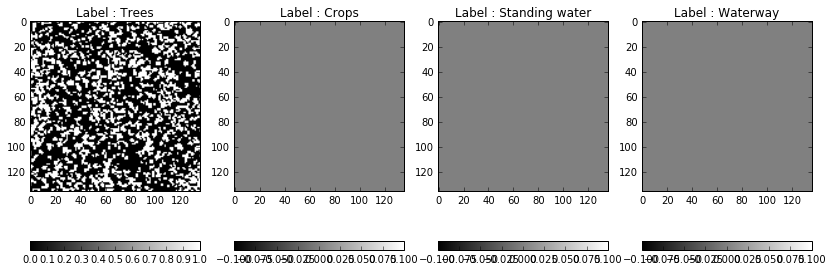

In [120]:
batch_size = 5
for X, Y in generate_images(train_files, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        n, m = 3, int(_channels * 1.0 / 3.0 + 1.0)
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,0,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [121]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from unet_3d import unet_zero

In [122]:
deep=False 
n_filters_0=32

model = unet_zero(n_labels, n_channels, size[0], size[1], deep=deep, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "unet_3d_zero_%i_%i_%s_%i.h5.store" % (n_channels, n_labels, str(deep), n_filters_0))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [123]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 1, 56, 136, 13 0                                            
____________________________________________________________________________________________________
convolution3d_140 (Convolution3D (None, 32, 56, 136, 1 896         input_22[0][0]                   
____________________________________________________________________________________________________
maxpooling3d_63 (MaxPooling3D)   (None, 32, 28, 68, 68 0           convolution3d_140[0][0]          
____________________________________________________________________________________________________
convolution3d_141 (Convolution3D (None, 64, 28, 68, 68 55360       maxpooling3d_63[0][0]            
___________________________________________________________________________________________

In [ ]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
model.compile(optimizer=Adadelta(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [ ]:
batch_size = 8
samples_per_epoch = 32
nb_val_samples = 16

print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_files, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=10,
    validation_data=generate_images(val_files, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

8 32 16


In [ ]:
plt.plot(history.history['val_jaccard_coef'])
plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [ ]:
batch_size = 5

for X, Y in generate_images(train_files, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,0,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break
